# Imports

In [77]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import geopy.distance

# Functions

In [2]:
def coordsDistance(coords1, coords2):
    return( geopy.distance.geodesic(coords1, coords2).miles )

# coords_1 = (52.2296756, 21.0122287)
# coords_2 = (52.406374, 16.9251681)

# print geopy.distance.vincenty(coords_1, coords_2).km

# Data Reading and Combinations

Part of the fun of this dataset is being able to combine it with Socrata's NYC open datasets

In [50]:
df = pd.read_csv("2016 School Explorer.csv")

In [183]:
df.shape

(1272, 161)

# Data

This dataset is from a company called PASSNYC, a not-for-profit organization that facilitates a collective impact that is dedicated to broadening educational opportunities for New York City's talented and underserved students.

PASSNYC uses public data to identify students within New York City’s under-performing school districts and, through consulting and collaboration with partners, aims to increase the diversity of students taking the Specialized High School Admissions Test (SHSAT)

Scores on the SHSAT
    - 1: Insufficient
    - 2: Partial but insufficient
    - 3: Sufficient
    - 4: More than sufficient
    
This dataset only catalogs if a student has scored a 4, to be able to represent how many students are truly ready for High School

In [129]:
class Data:
    """
        A wrapper class for the pandas DataFrame data type
        
        Used to store convenient exploratory data functions
    """
    def __init__(self, df):
        self.df = df
        self.length = len(df)
        
    def nans(self, threshold = 0, silence = False):
        """
        Shows the number of NaN values per column if the parameter silence is False
        Will always return the columns that have more NaN values than the threshold

        :param threshold: The number of NaNs is compared to this and will will return /
            print the columns greater than this threshold
        :param silence: Whether or not to print the columns and number of NaNs to console 
        :return: A list of columns that have more NaNs than the threshold

        >>> Data.nans(threshold = 100)
            # Lines printed
            Adjusted Grade: 1270 null values
            New?: 1245 null values
            Other Location Code in LCGMS: 1271 null values
            School Income Estimate: 396 null values
            
            # List returned
            ['Adjusted Grade',
             'New?',
             'Other Location Code in LCGMS',
             'School Income Estimate']
        """
        
        # TODO: Currently it makes a comparison every loop instead of just one comparison
        # Try and split the iteration call into a separate function
        
        return_list = []
        for (col_name, col_data) in self.df.iteritems():
            nan = self.df[col_name].isnull().sum()
            if nan > threshold:
                if silence == False:
                    print(col_name + ": %d null values" % nan)
                return_list.append(col_name)
        return return_list
    
    def dollarsToDigits(self, s):
        """
        Converts the string representation of a budget into a float
        
        :param s: String to convert
        :return s: A float version of the string
        """
        try:
            s = s.replace('$', '')
        except:
        # In the event that the value is NaN
            return(0)
        s = s.replace(',', '')
        return(float(s))
    
    def percents_to_floats(self, s):
        """
        Converts the string representation of a float into a decimal representation of a float
        
        :param s: string float to convert
        :return: A float version of the string
        
        >>> percents_to_floats('%9')
            0.09 #As float
        """
        try:
            s = s.replace('%', '')
        except:
        # In the event that the value is NaN
            return(0)
        return(float(s) / 100)
    
    def drop_cols(self, col_list):
        """
        Takes in a list of columns and drops them, in-place
        
        :param col_list: A list of columns to drop
        :return: Nothing, the operation happens in-place
        
        """
        # axis = 1 represents dropping from columns. 0 would be index
        self.df.drop( col_list, axis = 1, inplace = True )
        
    def dict_fun_run(self, dic, fun):
        """
        Iterates a function over a nested dictionary of dictionaries
        
        :param dict: Takes a nested dictionary in this form. {1:{'fizz':'buzz'}, 2:{'buzz':'fizz'}}
        :return: Nothing, just runs the given function over the items in the dictionary
        """
        for item in dic.items():
            fun(**item[1])
            
        return
    
    def _column_bin(self, **kwargs):
        """
        Generates categorical columns based on numerical values, automatically splitting based on inputted bin size
        """
        self.df[kwargs['new_col']] = pd.cut(self.df[kwargs['cut_col']], kwargs['bin_size'],
                                            labels = kwargs['labels'])
        return
    
    def _column_div(self, **kwargs):
        """
        Generates columns through division based on a numerator and denominator column
        """
        self.df[kwargs['new_col']] = (self.df[kwargs['div_top']] / self.df[kwargs['div_bot']]).fillna(0)
        return

    def imputer(self, col, miss_value = np.NaN, strat = 'median'):
        """
        Runs an imputation strategy of the user's choice and assigns that back to the column, replacing all missing values
        """
        imputed_col = SimpleImputer(missing_values = miss_value, strategy = strat)
        imputed_col.fit(self.df[[col]])
        self.df[col] = imputed_col.transform(self.df[[col]])
    
        return
    
    def cat_impute(self, col):
        """
        Imputes a categorical value with the most likely candidate
        """
        self.df[col] = self.df[col].fillna(self.df[col].mode().iloc[0])


class SchoolData(Data):
    """
        A Data-inherited class designed to specifically deal with dataset
    """

    def __init__(self, df):
        super().__init__(df)
        # A collection of columns that will be created and summed based on the arguments sent into columnGenerator
        self.__sum_dict = {
            1:{ 'new_col':'Students Tested Total','subject':'both','students':'All Students', 'test':True },
            2:{ 'new_col':'Student Tested 4s','subject':'both','students':'All Students', 'test':False },
            3:{ 'new_col':'Math Tested Total','subject':'Math','students':'All Students', 'test':True },
            4:{ 'new_col':'Math Tested 4s','subject':'Math','students':'All Students', 'test':False },
            5:{ 'new_col':'ELA Tested Total','subject':'ELA','students':'All Students', 'test':True },
            6:{ 'new_col':'ELA Tested 4s','subject':'ELA','students':'All Students', 'test':False },
            7:{ 'new_col':'White Students Total','subject':'both','students':'White', 'test':False },
            8:{ 'new_col':'Asian / Pacific Islanders Students Total','subject':'both',
                'students':'Asian', 'test':False },
            9:{ 'new_col':'Black Students Total','subject':'both',
                'students':'Black', 'test':False },
           10:{ 'new_col':'Hispanic / Latino Students Total','subject':'both',
                'students':'Hispanic', 'test':False },
           11:{ 'new_col':'American Indian / Alaska Native Students Total','subject':'both',
                'students':'American', 'test':False },
           12:{ 'new_col':'Multiracial Students Total','subject':'both',
                'students':'Multiracial', 'test':False },
           13:{ 'new_col':'Limited English Students Total','subject':'both',
                'students':'Limited', 'test':False },
           14:{ 'new_col':'Economically Disadvantaged Students Total','subject':'both',
                'students':'Economically', 'test':False }
           }
        # A collection of columns to be generated and the columns that need to be divided to get that value
        self.__div_dict = {
            1:{ 'new_col':'Total 4 %', 'div_top':'Student Tested 4s', 'div_bot':'Students Tested Total'},
            2:{ 'new_col':'Math Prop 4', 'div_top':'Math Tested 4s', 'div_bot':'Math Tested Total'},
            3:{ 'new_col':'ELA Prop 4', 'div_top':'ELA Tested 4s', 'div_bot':'ELA Tested Total'},
            4:{ 'new_col':'White Students %', 'div_top':'White Students Total', 'div_bot':'4 Tested Total'},
            5:{ 'new_col':'Asian / Pacific Islanders Students %',
                'div_top':'Asian / Pacific Islanders Students Total', 'div_bot':'4 Tested Total'},
            6:{ 'new_col':'Black Students %', 'div_top':'Black Students Total', 'div_bot':'4 Tested Total'},
            7:{ 'new_col':'Hispanic / Latino Students %',
                'div_top':'Hispanic / Latino Students Total', 'div_bot':'4 Tested Total'},
            8:{ 'new_col':'American Indian / Alaska Native Students %',
                'div_top':'American Indian / Alaska Native Students Total', 'div_bot':'4 Tested Total'},
            9:{ 'new_col':'Multiracial Students %', 'div_top':'Multiracial Students Total',
                'div_bot':'4 Tested Total'},
           10:{ 'new_col':'Limited English Students %', 'div_top':'Limited English Students Total',
                 'div_bot':'4 Tested Total'},
           11:{ 'new_col':'Economically Disadvantaged Students%', 'div_top':'Economically Disadvantaged Students Total',
                'div_bot':'4 Tested Total'}
           }
        # Collection of columns to be categorically split with pd.cut()
        self.__bin_dict = {
            1:{'new_col':'Income Bin', 'cut_col':'School Income Estimate',
               'bin_size':4, 'labels':['low', 'medium', 'high', 'highest']},
            2:{'new_col':'ENI Bin', 'cut_col':'Economic Need Index',
               'bin_size':4, 'labels':['lowest', 'low', 'medium', 'high']},
            3:{'new_col':'Total % Bin', 'cut_col':'Total 4 %',
               'bin_size':3, 'labels':['low', 'medium', 'high']}
           }
        # Collection of column names to convert to percentages from objects
        self.__perc_cols = ['Percent ELL', 'Percent Asian', 'Percent Black', 'Percent Hispanic', 'Percent Black / Hispanic',
                           'Percent White', 'Student Attendance Rate', 'Percent of Students Chronically Absent',
                           'Rigorous Instruction %', 'Collaborative Teachers %', 'Supportive Environment %',
                           'Effective School Leadership %', 'Strong Family-Community Ties %', 'Trust %']
        self.__impute_dict = {
            1: {'col':'Economic Need Index', 'miss_value':np.NaN, 'strat': 'median'},
            2: {'col':'Average ELA Proficiency', 'miss_value':np.NaN, 'strat': 'median'},
            3: {'col':'Average Math Proficiency', 'miss_value':np.NaN, 'strat': 'median'}
            }
        self.__cat_impute = ['Rigorous Instruction Rating', 'Collaborative Teachers Rating', 'Supportive Environment Rating',
                            'Effective School Leadership Rating', 'Strong Family-Community Ties Rating',
                            'Trust Rating', 'Student Achievement Rating', 'ENI Bin']
        self._type_correction()
        self._feature_engineering()
        self.dict_fun_run(self.__impute_dict, self.imputer)
        for col in self.__cat_impute:
            self.cat_impute(col)

    def column_generator(self, subject = 'both', students = 'All Students', test = False):
        """
        Generates a list of columns based on the input given
        
        :param subject: School subject, must be: 'both', 'Math', or 'Ela'
        :param students: Filters for the type of student, 'All Students' is default
        :param test: Also returns for columns that end in ' Tested' if True
        :return: A list of columns from the data
        
        >>> data.column_generator(test = True, subject = 'ELA')
        ['Grade 3 ELA - All Students Tested',
         'Grade 4 ELA - All Students Tested',
         'Grade 5 ELA - All Students Tested',
         'Grade 6 ELA - All Students Tested',
         'Grade 7 ELA - All Students Tested',
         'Grade 8 ELA - All Students Tested']
         
        >>> data.column_generator(test = False, subject = 'Math')
        ['Grade 3 Math 4s - All Students',
         'Grade 4 Math 4s - All Students',
         'Grade 5 Math 4s - All Students',
         'Grade 6 Math 4s - All Students',
         'Grade 7 Math 4s - All Students',
         'Grade 8 Math 4s - All Students']
        """
        # Ensures subject is assigned correctly
        assert subject in ['both', 'Math', 'ELA'], 'Subject must be: both, Math, or ELA'

        if test:
            assert students == 'All Students', 'test Flag should only be set true with All Students'
            students += ' Tested'
        else:
            students = '4s - ' + students

        # Stores a list of all the columns
        cols = list(self.df.columns)

        if subject == 'both':
            return [i for i in cols if students in i and ('ELA' in i or 'Math' in i)]
        elif subject == 'Math':
            return [i for i in cols if students in i and 'Math' in i]
        elif subject == 'ELA':
            return [i for i in cols if students in i and 'ELA' in i]
        else:
            return -1 #An error has occurred
        
    def _type_correction(self):
        """
        #TODO: An eventual place to put all my type configs
        """
        self.df['School Income Estimate'] = self.df['School Income Estimate'].apply(self.dollarsToDigits)
        
        # Converts all object style percents to float style percents
        for col in self.__perc_cols:
            self.df[col] = self.df[col].apply(self.percents_to_floats)
            
        self.df['Community School?'] = self.df['Community School?'].map({'Yes': 1, 'No': 0})
        
    def _clean_data(self):
        """
        A collection of operations to help readability and processing of data
        """
        # Fix a spelling mistake to ensure that all columns match the same pattern
        self.df.rename(columns = {'Grade 3 Math - All Students tested':'Grade 3 Math - All Students Tested'},
                       inplace = True)
        
        # Column needed for upcoming processing
        self.df['4 Tested Total'] = self.df['Math Tested 4s'] + self.df['ELA Tested 4s']
        column_4s = ['White Students Total',
             'Asian / Pacific Islanders Students Total',
             'Black Students Total',
             'Hispanic / Latino Students Total',
             'American Indian / Alaska Native Students Total',
             'Multiracial Students Total']
        
        # Operations that fit outside the dictionaries for organization regions
        self.df['Ethnicity Tested Total'] = self.df[column_4s].apply(sum, axis = 1)
        self.df['Nonreported Ethnicity Total'] = self.df['4 Tested Total'] - self.df['Ethnicity Tested Total']
        self.df['Nonreported Ethnicity %'] = (self.df['Nonreported Ethnicity Total'] / self.df['4 Tested Total']).fillna(0)
        
        return
    
    def _feature_engineering(self):
        """
        Organizes, cleans, and feature engineers columns for the data
        
        Responsibilities:
            - Fixes some readability
            - Columns based around sums
            - Columns based around division
            - Columns based around bins
            - Organizes the Grades
            - Drops superfluous columns
        """
        
        # Set to retain only unique items, filled with some base columns I won't be using
        drop_cols = set(['Adjusted Grade', 'New?', 'Other Location Code in LCGMS', 'SED Code', 'Location Code',
                        'Address (Full)'])
        
        # Engineer all features that involve sums
        drop_cols = self._process_drop_features( self.__sum_dict, drop_cols )
        
        # Help make the data more readable, must be called after the above line
        self._clean_data()
        
        # Engineer all features that involve division
        self.dict_fun_run(self.__div_dict, self._column_div)
        # Engineer all features that involve bins (pd.cut)
        self.dict_fun_run(self.__bin_dict, self._column_bin)
        # Organize grades
        self._grade_combination()
        
        # Make sure not to drop columns concerning all students
        drop_cols = [i for i in drop_cols if 'All Students' not in i]

        # Drop superfluous columns
        self.drop_cols( drop_cols )
        
        del self.__sum_dict
        del self.__bin_dict
        del self.__div_dict
        del self.__perc_cols
        
        return
    
    # TODO: Column re-naming function, takes in an original and a new 
    
    def _column_sum(self, **kwargs):
        """
        Generates columns using column_generator, sums them, and assigns them to a new column
        
        :return: The list of columns that were summed based on the **kwargs arguments sent in
        """
        col_data = self.column_generator(subject = kwargs['subject'],students = kwargs['students'], test = kwargs['test'])
        self.df[kwargs['new_col']] = self.df[col_data].apply(sum, axis = 1)
        return(col_data)
    
    def _process_drop_features(self, dic, drop_cols):
        """
        Using column_generator and _column_sum, adds all of the values of the columns generated and stores the sum
        into the provided column in new_col
        
        :param drop_cols: A set that will be updated with columns to drop
        :return: A set of columns
        """
        # new_col is the name of the new column that will be updated with the sums of all values generated by
        # column_generator
        # Each nested dictionary acts as a list of **kwargs arguments for _column_sum
        
        for item in dic.items():
            drop_cols.update( self._column_sum(**item[1]) )
            
        return drop_cols
    
    def _grade_combination(self):
        """
        Sums all the like Grades 4 scores and stores it in a new total column
        
        :return: Nothing, all columns are assigned in the function
        """
        cols = list(self.df.columns)
        for grade in range(3, 8 + 1):
            col_data = [i for i in cols if ('Grade ' + str(grade) in i) and ('All Students' in i) and ('Tested' not in i)]
            self.df['Grade ' + str(grade) + ' 4s Total'] = self.df[col_data].apply(sum, axis = 1)
        return

In [132]:
df = pd.read_csv("2016 School Explorer.csv")
# print(df.shape)
# Load data into a Data Class
data = SchoolData(df)
data.df.head(3)
# data.df.shape
# df.dtypes

# data.imputer('Economic Need Index')

# data.df['Economic Need Index']

# data.impute_cols()

# data.nans()

# data.df['Rigorous Instruction Rating'] = data.df['Rigorous Instruction Rating'].fillna(data.df['Rigorous Instruction Rating'].mode().iloc[0])

#TODO: I really want to have a total number of 4s for each subject and both for all the different Grades
#TODO: Think about creating a bool column for each possible grade that can be at a school

,School Name,District,Latitude,Longitude,City,Zip,Grades,Grade Low,Grade High,Community School?,Economic Need Index,School Income Estimate,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Rigorous Instruction Rating,Collaborative Teachers %,Collaborative Teachers Rating,Supportive Environment %,Supportive Environment Rating,Effective School Leadership %,Effective School Leadership Rating,Strong Family-Community Ties %,Strong Family-Community Ties Rating,Trust %,Trust Rating,Student Achievement Rating,Average ELA Proficiency,Average Math Proficiency,Grade 3 ELA - All Students Tested,Grade 3 ELA 4s - All Students,Grade 3 Math - All Students Tested,Grade 3 Math 4s - All Students,Grade 4 ELA - All Students Tested,Grade 4 ELA 4s - All Students,Grade 4 Math - All Students Tested,Grade 4 Math 4s - All Students,Grade 5 ELA - All Students Tested,Grade 5 ELA 4s - All Students,Grade 5 Math - All Students Tested,Grade 5 Math 4s - All Students,Grade 6 ELA - All Students Tested,Grade 6 ELA 4s - All Students,Grade 6 Math - All Students Tested,Grade 6 Math 4s - All Students,Grade 7 ELA - All Students Tested,Grade 7 ELA 4s - All Students,Grade 7 Math - All Students Tested,Grade 7 Math 4s - All Students,Grade 8 ELA - All Students Tested,Grade 8 ELA 4s - All Students,Grade 8 Math - All Students Tested,Grade 8 Math 4s - All Students,Students Tested Total,Student Tested 4s,Math Tested Total,Math Tested 4s,ELA Tested Total,ELA Tested 4s,White Students Total,Asian / Pacific Islanders Students Total,Black Students Total,Hispanic / Latino Students Total,American Indian / Alaska Native Students Total,Multiracial Students Total,Limited English Students Total,Economically Disadvantaged Students Total,4 Tested Total,Ethnicity Tested Total,Nonreported Ethnicity Total,Nonreported Ethnicity %,Total 4 %,Math Prop 4,ELA Prop 4,White Students %,Asian / Pacific Islanders Students %,Black Students %,Hispanic / Latino Students %,American Indian / Alaska Native Students %,Multiracial Students %,Limited English Students %,Economically Disadvantaged Students%,Income Bin,ENI Bin,Total % Bin,Grade 3 4s Total,Grade 4 4s Total,Grade 5 4s Total,Grade 6 4s Total,Grade 7 4s Total,Grade 8 4s Total
0,P.S. 015 ROBERTO CLEMENTE,1,40.721834,-73.978766,NEW YORK,10009,"PK,0K,01,02,03,04,05",PK,05,1,0.919,31141.72,0.09,0.05,0.32,0.60,0.92,0.01,0.94,0.18,0.89,Meeting Target,0.94,Meeting Target,0.86,Exceeding Target,0.91,Exceeding Target,0.85,Meeting Target,0.94,Exceeding Target,Approaching Target,2.14,2.17,20,0,21,0,15,0,15,2,16,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,82,2,31,2,51,0,0,0,0,0,0,0,0,0,2,0,2,1.000000,0.024390,0.064516,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,low,high,low,0,2,0,0,0,0
1,P.S. 019 ASHER LEVY,1,40.729892,-73.984231,NEW YORK,10003,"PK,0K,01,02,03,04,05",PK,05,0,0.641,56462.88,0.05,0.10,0.20,0.63,0.83,0.06,0.92,0.30,0.96,Meeting Target,0.96,Meeting Target,0.97,Meeting Target,0.90,Exceeding Target,0.86,Meeting Target,0.94,Meeting Target,Exceeding Target,2.63,2.98,33,2,33,6,29,5,28,10,32,7,32,4,0,0,0,0,0,0,0,0,0,0,0,0,154,34,60,20,94,14,0,4,6,13,0,0,0,24,34,23,11,0.323529,0.220779,0.333333,0.148936,0.000000,0.117647,0.176471,0.382353,0.0,0.0,0.000000,0.705882,medium,medium,low,8,15,11,0,0,0
2,P.S. 020 ANNA SILVER,1,40.721274,-73.986315,NEW YORK,10002,"PK,0K,01,02,03,04,05",PK,05,0,0.744,44342.61,0.15,0.35,0.08,0.49,0.57,0.04,0.94,0.20,0.87,Meeting Target,0.77,Meeting Target,0.82,Approaching Target,0.61,Not Meeting Target,0.80,Approaching Target,0.79,Not Meeting Target,Approaching Target,2.39,2.54,76,6,76,11,70,9,71,13,73,2,73,10,0,0,0,0,0,0,0,0,0,0,0,0,363,51,144,34,219,17,4,38,0,6,0,0,1,19,51,48,3,0.058824,0.140496,0.236111,0.077626,0.078431,0.745098,0.000000,0.117647,0.0,0.0,0.019608,0.372549,low,high,low,17,22,12,0,0,0


### Possible Food Deserts

[This is a list of Grocery Stores in NYC](https://data.ny.gov/Economic-Development/Retail-Food-Stores/9a8c-vfzj). One possible idea I had for schools in need was being in a close proximity to a Food Desert. I took the list of Grocery stores and got a count of them for every zip code and merged it with the dataset of schools.

In [116]:
%time
retail_food_df = pd.read_csv('Retail_Food_Stores.csv')

retail_food_df['Establishment Type'] = [ i.strip() for i in retail_food_df['Establishment Type'] ]
retail_zips = pd.DataFrame(retail_food_df[retail_food_df['Establishment Type'] == 'A'].groupby('Zip Code').count().loc[:,'County'])
retail_zips = retail_zips.reset_index()
retail_zips.columns = ['Zip', 'Grocery Store Count']

df = pd.merge(df, retail_zips, on = 'Zip', how = 'left')

del retail_food_df
del retail_zips

# Convert to integer values and fill empty values with 0
df['Grocery Store Count'] = df['Grocery Store Count'].fillna(0)
df['Grocery Store Count'] = df['Grocery Store Count'].astype(int)

Wall time: 0 ns


In [5]:
df[['School Name', 'Grocery Store Count', 'Zip']].head()

,School Name,Grocery Store Count,Zip
0,P.S. 015 ROBERTO CLEMENTE,15,10009
1,P.S. 019 ASHER LEVY,29,10003
2,P.S. 020 ANNA SILVER,50,10002
3,P.S. 034 FRANKLIN D. ROOSEVELT,15,10009
4,THE STAR ACADEMY - P.S.63,15,10009


In [117]:
perc_cols = ['Percent ELL',
             'Percent Asian',
             'Percent Black',
             'Percent Hispanic',
             'Percent Black / Hispanic',
             'Percent White',
             'Student Attendance Rate',
             'Percent of Students Chronically Absent',
             'Rigorous Instruction %',
             'Collaborative Teachers %',
             'Supportive Environment %',
             'Effective School Leadership %',
             'Strong Family-Community Ties %',
             'Trust %']

def PercToFloat(st):
    s = st[:-1]
    s = float(s) / 100
    return s

df[perc_cols] = df[perc_cols].fillna('0%')

for col in perc_cols:
    df[col] = df[col].apply(PercToFloat)

In [7]:
df[perc_cols].head()

,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Collaborative Teachers %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Trust %
0,0.09,0.05,0.32,0.60,0.92,0.01,0.94,0.18,0.89,0.94,0.86,0.91,0.85,0.94
1,0.05,0.10,0.20,0.63,0.83,0.06,0.92,0.30,0.96,0.96,0.97,0.90,0.86,0.94
2,0.15,0.35,0.08,0.49,0.57,0.04,0.94,0.20,0.87,0.77,0.82,0.61,0.80,0.79
3,0.07,0.05,0.29,0.63,0.92,0.04,0.92,0.28,0.85,0.78,0.82,0.73,0.89,0.88
4,0.03,0.04,0.20,0.65,0.84,0.10,0.93,0.23,0.90,0.88,0.87,0.81,0.89,0.93


C:\Users\Wes\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1152x432 with 0 Axes>

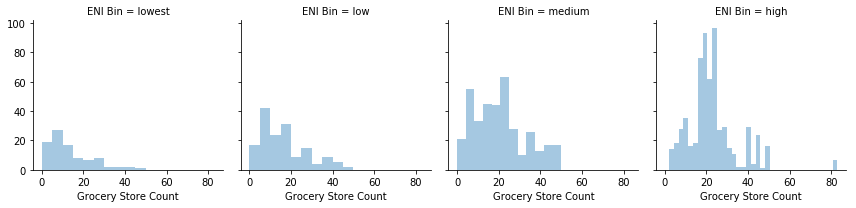

In [17]:
plt.figure(figsize=(16, 6))
g = sns.FacetGrid(df, col = 'ENI Bin')
g.map(sns.distplot, 'Grocery Store Count', kde = False)

In [18]:
corr = df.corr()
s = corr.unstack()
so = s.sort_values(kind = 'quicksort')

In [19]:
so.dropna()['Economic Need Index']

Average ELA Proficiency                              -0.806292
Percent White                                        -0.771980
ELA Prop 4                                           -0.733051
Average Math Proficiency                             -0.715865
Total 4 %                                            -0.696512
Math Prop 4                                          -0.641376
Grade 4 ELA 4s - White                               -0.577271
Grade 5 ELA 4s - White                               -0.569760
Grade 3 Math 4s - White                              -0.569264
Grade 4 Math 4s - White                              -0.568891
Grade 5 Math 4s - White                              -0.565246
Grade 3 ELA 4s - White                               -0.547855
School Income Estimate                               -0.518119
Grade 5 ELA 4s - All Students                        -0.516448
ELA Tested 4s                                        -0.505101
Student Tested 4s                                    -0

In [20]:
df['Trust %'].head()

0    0.94
1    0.94
2    0.79
3    0.88
4    0.93
Name: Trust %, dtype: float64

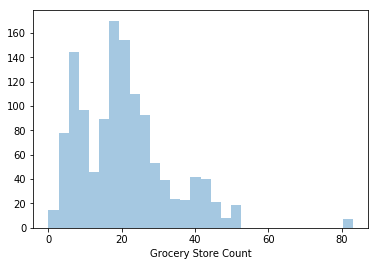

In [21]:
col = 'Grocery Store Count'

sns.distplot(df[col], kde=False)
# groc.describe()

In [132]:
len(df[df['Total 4 %'] <= 0.10])

674

In [112]:
df.head(5)

,Adjusted Grade,New?,Other Location Code in LCGMS,School Name,SED Code,Location Code,District,Latitude,Longitude,Address (Full),City,Zip,Grades,Grade Low,Grade High,Community School?,Economic Need Index,School Income Estimate,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Rigorous Instruction Rating,Collaborative Teachers %,Collaborative Teachers Rating,Supportive Environment %,Supportive Environment Rating,Effective School Leadership %,Effective School Leadership Rating,Strong Family-Community Ties %,Strong Family-Community Ties Rating,Trust %,Trust Rating,Student Achievement Rating,Average ELA Proficiency,Average Math Proficiency,Grade 3 ELA - All Students Tested,Grade 3 ELA 4s - All Students,Grade 3 ELA 4s - American Indian or Alaska Native,Grade 3 ELA 4s - Black or African American,Grade 3 ELA 4s - Hispanic or Latino,Grade 3 ELA 4s - Asian or Pacific Islander,Grade 3 ELA 4s - White,Grade 3 ELA 4s - Multiracial,Grade 3 ELA 4s - Limited English Proficient,Grade 3 ELA 4s - Economically Disadvantaged,Grade 3 Math - All Students tested,Grade 3 Math 4s - All Students,Grade 3 Math 4s - American Indian or Alaska Native,Grade 3 Math 4s - Black or African American,Grade 3 Math 4s - Hispanic or Latino,Grade 3 Math 4s - Asian or Pacific Islander,Grade 3 Math 4s - White,Grade 3 Math 4s - Multiracial,Grade 3 Math 4s - Limited English Proficient,Grade 3 Math 4s - Economically Disadvantaged,Grade 4 ELA - All Students Tested,Grade 4 ELA 4s - All Students,Grade 4 ELA 4s - American Indian or Alaska Native,Grade 4 ELA 4s - Black or African American,Grade 4 ELA 4s - Hispanic or Latino,Grade 4 ELA 4s - Asian or Pacific Islander,Grade 4 ELA 4s - White,Grade 4 ELA 4s - Multiracial,Grade 4 ELA 4s - Limited English Proficient,Grade 4 ELA 4s - Economically Disadvantaged,Grade 4 Math - All Students Tested,Grade 4 Math 4s - All Students,Grade 4 Math 4s - American Indian or Alaska Native,Grade 4 Math 4s - Black or African American,Grade 4 Math 4s - Hispanic or Latino,Grade 4 Math 4s - Asian or Pacific Islander,Grade 4 Math 4s - White,Grade 4 Math 4s - Multiracial,Grade 4 Math 4s - Limited English Proficient,Grade 4 Math 4s - Economically Disadvantaged,Grade 5 ELA - All Students Tested,Grade 5 ELA 4s - All Students,Grade 5 ELA 4s - American Indian or Alaska Native,Grade 5 ELA 4s - Black or African American,Grade 5 ELA 4s - Hispanic or Latino,Grade 5 ELA 4s - Asian or Pacific Islander,Grade 5 ELA 4s - White,Grade 5 ELA 4s - Multiracial,Grade 5 ELA 4s - Limited English Proficient,Grade 5 ELA 4s - Economically Disadvantaged,Grade 5 Math - All Students Tested,Grade 5 Math 4s - All Students,Grade 5 Math 4s - American Indian or Alaska Native,Grade 5 Math 4s - Black or African American,Grade 5 Math 4s - Hispanic or Latino,Grade 5 Math 4s - Asian or Pacific Islander,Grade 5 Math 4s - White,Grade 5 Math 4s - Multiracial,Grade 5 Math 4s - Limited English Proficient,Grade 5 Math 4s - Economically Disadvantaged,Grade 6 ELA - All Students Tested,Grade 6 ELA 4s - All Students,Grade 6 ELA 4s - American Indian or Alaska Native,Grade 6 ELA 4s - Black or African American,Grade 6 ELA 4s - Hispanic or Latino,Grade 6 ELA 4s - Asian or Pacific Islander,Grade 6 ELA 4s - White,Grade 6 ELA 4s - Multiracial,Grade 6 ELA 4s - Limited English Proficient,Grade 6 ELA 4s - Economically Disadvantaged,Grade 6 Math - All Students Tested,Grade 6 Math 4s - All Students,Grade 6 Math 4s - American Indian or Alaska Native,Grade 6 Math 4s - Black or African American,Grade 6 Math 4s - Hispanic or Latino,Grade 6 Math 4s - Asian or Pacific Islander,Grade 6 Math 4s - White,Grade 6 Math 4s - Multiracial,Grade 6 Math 4s - Limited English Proficient,Grade 6 Math 4s - Economically Disadvantaged,Grade 7 ELA - All Students Tested,Grade 7 ELA 4s - All Students,Grade 7 ELA 4s - American Indian or Alaska Native,Grade 7 ELA 4s - Black or African American,Grade 7 ELA 4s - His

In [72]:
cit_df = df.groupby('City').agg({'Students Tested Total': 'sum',
                       'Grocery Store Count': 'sum',
                       'SED Code': 'count',
                       'Car Crash Count': 'sum',
                       'Math Tested Total' : 'sum',
                       'ELA Tested Total' : 'sum',
                       'Economic Need Index': 'mean',
                       'Total 4 %': 'mean',
                       'Math Prop 4': 'mean',
                       'ELA Prop 4': 'mean'})
cit_df

,Students Tested Total,Grocery Store Count,SED Code,Car Crash Count,Math Tested Total,ELA Tested Total,Economic Need Index,Total 4 %,Math Prop 4,ELA Prop 4
City,,,,,,,,,,
ARVERNE,1284,4,2,10738.0,608,676,0.784500,0.034263,0.019531,0.048317
ASTORIA,3614,68,6,22438.0,1809,1805,0.512833,0.271255,0.298881,0.241657
BAYSIDE,9363,46,13,49118.0,4507,4856,0.276308,0.365129,0.470986,0.260595
BELLEROSE,2420,12,4,13266.0,1193,1227,0.267250,0.276113,0.326371,0.226321
BROAD CHANNEL,250,6,1,5369.0,125,125,0.304000,0.184000,0.160000,0.208000
BRONX,186348,6070,297,1983029.0,93437,92911,0.814729,0.076172,0.092958,0.059191
BROOKLYN,255655,10993,411,4083041.0,127340,128315,0.704429,0.134094,0.162078,0.105966
CAMBRIA HEIGHTS,1557,18,2,15356.0,777,780,0.430000,0.156101,0.148603,0.163568
COLLEGE POINT,1702,24,2,9814.0,862,840,0.517500,0.197729,0.268891,0.124783


In [62]:
zip_df = df.groupby('Zip').agg({'Students Tested Total': 'sum',
                       'Grocery Store Count': 'sum',
                       'SED Code': 'count',
                       'Car Crash Count': 'sum',
                       'Math Tested Total' : 'sum',
                       'ELA Tested Total' : 'sum',
                       'Economic Need Index': 'mean',
                       'Total 4 %': 'mean',
                       'Math Prop 4': 'mean',
                       'ELA Prop 4': 'mean'})
zip_df.head()

,Students Tested Total,Grocery Store Count,SED Code,Car Crash Count,Math Tested Total,ELA Tested Total,Economic Need Index,Total 4 %,Math Prop 4,ELA Prop 4
Zip,,,,,,,,,,
10001,861,46,2,13623.0,433,428,0.521500,0.272291,0.312163,0.232099
10002,9538,950,19,148237.0,4749,4789,0.728947,0.196224,0.257125,0.134980
10003,2672,232,8,63886.0,1287,1385,0.382571,0.380326,0.411355,0.349140
10004,645,6,1,13455.0,320,325,0.564000,0.217054,0.281250,0.153846
10007,600,10,1,8221.0,300,300,0.065000,0.376667,0.416667,0.336667


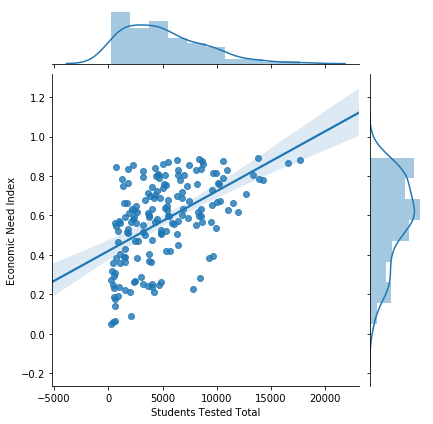

In [67]:
p = sns.jointplot(x = 'Students Tested Total', y = 'Economic Need Index', data = zip_df,
                  kind = 'reg')

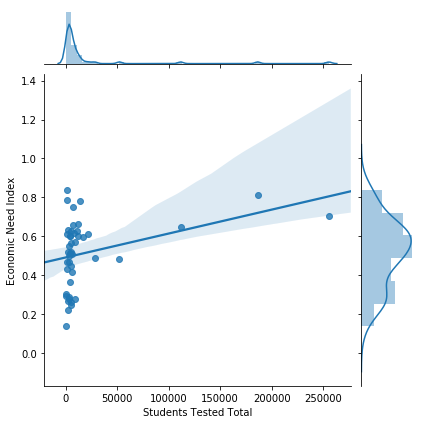

In [73]:
p = sns.jointplot(x = 'Students Tested Total', y = 'Economic Need Index', data = cit_df,
                  kind = 'reg')

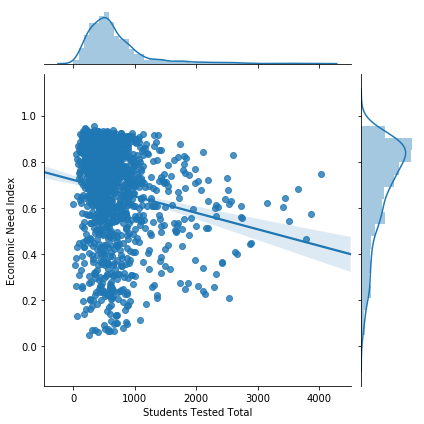

In [68]:
p = sns.jointplot(x = 'Students Tested Total', y = 'Economic Need Index', data = df,
                  kind = 'reg')

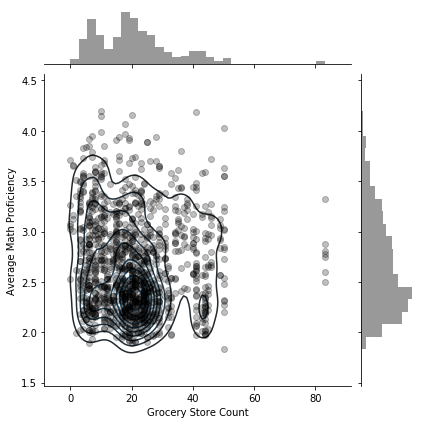

In [36]:
p = sns.jointplot(x = 'Grocery Store Count', y = 'Average Math Proficiency', data = df,
                  color = 'k', alpha = 0.25).plot_joint(sns.kdeplot, zorder = 0, n_levels = 10)

Looking at the Histogram of grocery stores nearby for school, it appears to be right skewed

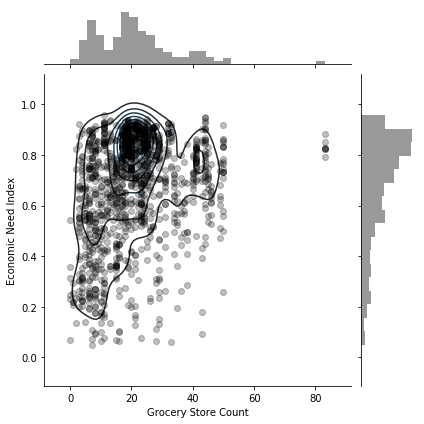

In [34]:
p = sns.jointplot(x = 'Grocery Store Count', y = 'Economic Need Index', data = df,
                  color = 'k', alpha = 0.25).plot_joint(sns.kdeplot, zorder = 0, n_levels = 10)

There are definitely some districts that have higher amounts of grocery stores than others, especially with the two 80s being outliers, and some have as little as 0

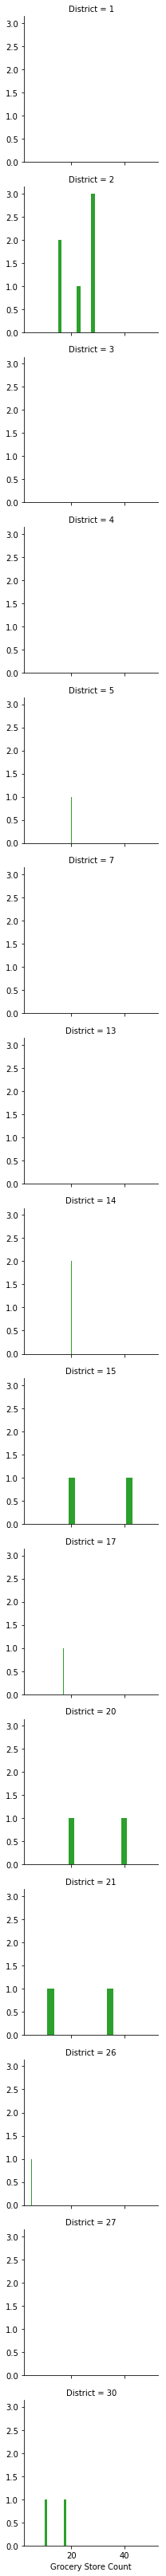

In [38]:
# plt.figure(figsize=(20, 6))
# p = sns.catplot(x = 'District', y = 'Grocery Store Count', data = df, row = 'Total % Bin')

# df2 = df[df['Total 4 %'] != 0]
g = sns.FacetGrid(df[df['Total % Bin'] == 'high'], hue = 'Total % Bin', row = 'District')
g = g.map(plt.hist, "Grocery Store Count")

In [88]:
df.tail()

,Adjusted Grade,New?,Other Location Code in LCGMS,School Name,SED Code,Location Code,District,Latitude,Longitude,Address (Full),City,Zip,Grades,Grade Low,Grade High,Community School?,Economic Need Index,School Income Estimate,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Rigorous Instruction Rating,Collaborative Teachers %,Collaborative Teachers Rating,Supportive Environment %,Supportive Environment Rating,Effective School Leadership %,Effective School Leadership Rating,Strong Family-Community Ties %,Strong Family-Community Ties Rating,Trust %,Trust Rating,Student Achievement Rating,Average ELA Proficiency,Average Math Proficiency,Grade 3 ELA - All Students Tested,Grade 3 ELA 4s - All Students,Grade 3 ELA 4s - American Indian or Alaska Native,Grade 3 ELA 4s - Black or African American,Grade 3 ELA 4s - Hispanic or Latino,Grade 3 ELA 4s - Asian or Pacific Islander,Grade 3 ELA 4s - White,Grade 3 ELA 4s - Multiracial,Grade 3 ELA 4s - Limited English Proficient,Grade 3 ELA 4s - Economically Disadvantaged,Grade 3 Math - All Students tested,Grade 3 Math 4s - All Students,Grade 3 Math 4s - American Indian or Alaska Native,Grade 3 Math 4s - Black or African American,Grade 3 Math 4s - Hispanic or Latino,Grade 3 Math 4s - Asian or Pacific Islander,Grade 3 Math 4s - White,Grade 3 Math 4s - Multiracial,Grade 3 Math 4s - Limited English Proficient,Grade 3 Math 4s - Economically Disadvantaged,Grade 4 ELA - All Students Tested,Grade 4 ELA 4s - All Students,Grade 4 ELA 4s - American Indian or Alaska Native,Grade 4 ELA 4s - Black or African American,Grade 4 ELA 4s - Hispanic or Latino,Grade 4 ELA 4s - Asian or Pacific Islander,Grade 4 ELA 4s - White,Grade 4 ELA 4s - Multiracial,Grade 4 ELA 4s - Limited English Proficient,Grade 4 ELA 4s - Economically Disadvantaged,Grade 4 Math - All Students Tested,Grade 4 Math 4s - All Students,Grade 4 Math 4s - American Indian or Alaska Native,Grade 4 Math 4s - Black or African American,Grade 4 Math 4s - Hispanic or Latino,Grade 4 Math 4s - Asian or Pacific Islander,Grade 4 Math 4s - White,Grade 4 Math 4s - Multiracial,Grade 4 Math 4s - Limited English Proficient,Grade 4 Math 4s - Economically Disadvantaged,Grade 5 ELA - All Students Tested,Grade 5 ELA 4s - All Students,Grade 5 ELA 4s - American Indian or Alaska Native,Grade 5 ELA 4s - Black or African American,Grade 5 ELA 4s - Hispanic or Latino,Grade 5 ELA 4s - Asian or Pacific Islander,Grade 5 ELA 4s - White,Grade 5 ELA 4s - Multiracial,Grade 5 ELA 4s - Limited English Proficient,Grade 5 ELA 4s - Economically Disadvantaged,Grade 5 Math - All Students Tested,Grade 5 Math 4s - All Students,Grade 5 Math 4s - American Indian or Alaska Native,Grade 5 Math 4s - Black or African American,Grade 5 Math 4s - Hispanic or Latino,Grade 5 Math 4s - Asian or Pacific Islander,Grade 5 Math 4s - White,Grade 5 Math 4s - Multiracial,Grade 5 Math 4s - Limited English Proficient,Grade 5 Math 4s - Economically Disadvantaged,Grade 6 ELA - All Students Tested,Grade 6 ELA 4s - All Students,Grade 6 ELA 4s - American Indian or Alaska Native,Grade 6 ELA 4s - Black or African American,Grade 6 ELA 4s - Hispanic or Latino,Grade 6 ELA 4s - Asian or Pacific Islander,Grade 6 ELA 4s - White,Grade 6 ELA 4s - Multiracial,Grade 6 ELA 4s - Limited English Proficient,Grade 6 ELA 4s - Economically Disadvantaged,Grade 6 Math - All Students Tested,Grade 6 Math 4s - All Students,Grade 6 Math 4s - American Indian or Alaska Native,Grade 6 Math 4s - Black or African American,Grade 6 Math 4s - Hispanic or Latino,Grade 6 Math 4s - Asian or Pacific Islander,Grade 6 Math 4s - White,Grade 6 Math 4s - Multiracial,Grade 6 Math 4s - Limited English Proficient,Grade 6 Math 4s - Economically Disadvantaged,Grade 7 ELA - All Students Tested,Grade 7 ELA 4s - All Students,Grade 7 ELA 4s - American Indian or Alaska Native,Grade 7 ELA 4s - Black or African American,Grade 7 ELA 4s - His

### Distance to a Metro

[Here is a list of Metro stations in NYC.](https://data.ny.gov/widgets/i9wp-a4ja). I took the co-ordinates for all the entrances to the stations and computed the shortest distance between a school and a station measured in Miles.

This is a Euclidean Distance between a given school and the closest Metro station, so it's meant to be more of a measurement of how close to public transit the school is and not a measurement of travel distance

This block of code is computationally expensive, so I ran it once, saved the data and then saved it as a separate .csv to reimport and use later.

In [118]:
# This magic line prevents the code from running
%%script false 

# Read in file
metro_df = pd.read_csv('NYC_Transit_Subway_Entrance_And_Exit_Data.csv')
# df.head()

# Create a tuple of co-ordinates to match the metro_df
df['Coords'] = [(i,j) for i, j in zip(df['Latitude'], df['Longitude'])]
# df['Coords']

# Read from bottom to top for most coherent explanation of the double list comprehension
            # Creates a tuple out of the two float numbers in a co-ordinate
stations = [tuple([float(number) for number in group]) \
            # Takes each string co-ordinate, and separates it into two float numbers (in string form)
            for group in [s.strip("()").split(",") \
                          # For each co-ordinate stored in the metro dataframe
                          for s in metro_df['Station Location']] ]

def returnClosestStation(coords):
    closest = -1
    for station in stations:
        distance = coordsDistance( station, coords)
        if distance > closest:
            closest = distance
    return closest

df['Closest Metro Station'] = df['Coords'].apply(returnClosestStation)

del metro_df
del stations

df['Closest Metro Station'].to_csv('Metro distances.csv', index = False)

UsageError: Line magic function `%%script` not found.


In [119]:
# Reloads computed code and adds it to the dataframe
metro_distance = pd.read_csv('Metro distances.csv')
df['Closest Metro Station'] = metro_distance
del metro_distance

In [11]:
df[['School Name','Closest Metro Station', 'Zip']].head()

,School Name,Closest Metro Station,Zip
0,P.S. 015 ROBERTO CLEMENTE,14.832886,10009
1,P.S. 019 ASHER LEVY,14.584245,10003
2,P.S. 020 ANNA SILVER,14.290696,10002
3,P.S. 034 FRANKLIN D. ROOSEVELT,14.706900,10009
4,THE STAR ACADEMY - P.S.63,14.475423,10009


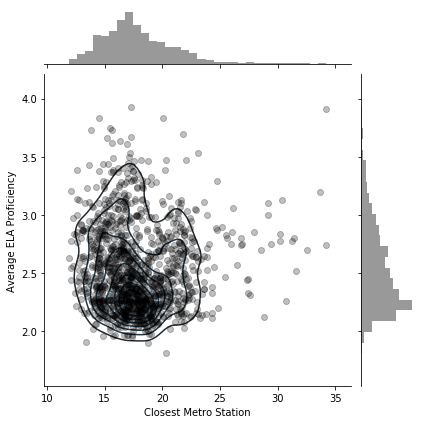

In [40]:
p = sns.jointplot(x = 'Closest Metro Station', y = 'Average ELA Proficiency', data = df,
                  color = 'k', alpha = 0.25).plot_joint(sns.kdeplot, zorder = 0, n_levels = 10)

### Car Safety

[This is a dataset about car crashes in NYC.](https://www.kaggle.com/new-york-city/nypd-motor-vehicle-collisions) I used this dataset as a measurement of how safe the roads are in NYC near these schools. Zip Codes were only tracked in this dataset if someone was injured in the car crash, meaning that these are only what can be considered moderate to severe car accidents.

In [120]:
# Code takes too long to compute, save and reimport

%%script false
%%time
crashes_df = pd.read_csv('nypd-motor-vehicle-collisions.csv')
# Many zip code values weren't kept track of, most of these were considered less severe car accidents so I dropped
# them all from the dataset
crashes_df = pd.DataFrame(crashes_df.dropna(subset = ['ZIP CODE']).groupby('ZIP CODE').count()['TIME'])
crashes_df = crashes_df.reset_index()
crashes_df.columns = ['Zip', 'Car Crash Count']

# Zip codes were not inputted well in this dataset, there were multiple formats for all zip codes, I went through a process
# of converting from strings to floats or ints or just returned as an empty string to drop later.

def convert(n):
    try:
        return(int(n))
    except:
        pass
    try:
        return(float(n))
    except:
        pass
    return(n.strip())

crashes_df['Zip'] = crashes_df['Zip'].apply(convert)
crashes_df = crashes_df[crashes_df['Zip'] != ''].astype(int)
crashes_df = crashes_df.groupby('Zip').sum()
df = pd.merge(df, crashes_df, on = 'Zip', how = 'left')

del crashes_df

df['Car Crash Count'].to_csv('Car Crash Count.csv', index = False)

UsageError: Line magic function `%%script` not found.


In [121]:
# Reloads computed code and adds it to the dataframe
car_crashes = pd.read_csv('Car Crash Count.csv')
df['Car Crash Count'] = car_crashes
del car_crashes

In [14]:
df[['School Name','Car Crash Count', 'Zip']].head()

,School Name,Car Crash Count,Zip
0,P.S. 015 ROBERTO CLEMENTE,8221.0,10009
1,P.S. 019 ASHER LEVY,11873.0,10003
2,P.S. 020 ANNA SILVER,4683.0,10002
3,P.S. 034 FRANKLIN D. ROOSEVELT,4683.0,10009
4,THE STAR ACADEMY - P.S.63,4683.0,10009


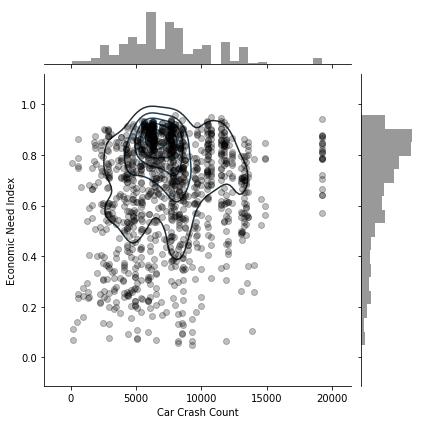

In [46]:
p = sns.jointplot(x = 'Car Crash Count', y = 'Economic Need Index', data = df,
                  color = 'k', alpha = 0.25).plot_joint(sns.kdeplot, zorder = 0, n_levels = 6)

# SAT Scores

There is a collection of schools that have their SAT scores posted online, unfortuantely it only matches with 61 of the school in this dataset. Given that there are over 1200 school I decided to not use this dataset

This makes sense as most of the schools in this dataset are not high school level or above

https://www.kaggle.com/new-york-city/new-york-city-sat-results/download#2012_SAT_Results_Data_Dictionary_.xlsx

ELA - English Language Performance Levels
    - 1: Insufficient
    - 2: Partial but insufficient
    - 3: Sufficient
    - 4: More than sufficient

,Grade 6 ELA - All Students Tested,Grade 7 ELA - All Students Tested,Grade 8 Math - All Students Tested,Grade 4 ELA - All Students Tested,Grade 5 Math - All Students Tested,Grade 3 Math - All Students Tested,Grade 8 ELA - All Students Tested,Grade 7 Math - All Students Tested,Grade 4 Math - All Students Tested,Grade 6 Math - All Students Tested,Grade 3 ELA - All Students Tested,Grade 5 ELA - All Students Tested
0,0,0,0,15,16,21,0,0,15,0,20,16
1,0,0,0,29,32,33,0,0,28,0,33,32
2,0,0,0,70,73,76,0,0,71,0,76,73
3,54,55,48,35,29,29,47,55,34,54,27,29
4,0,0,0,15,12,21,0,0,15,0,21,12
5,0,0,0,40,44,31,0,0,40,0,29,42
6,0,0,0,49,65,81,0,0,49,0,81,65
7,0,0,0,43,34,36,0,0,43,0,35,34
8,54,47,61,31,21,28,61,46,32,56,28,21
9,0,0,0,58,47,38,0,0,55,0,40,46


In [207]:
# This section gets all the total of the different grades for the listed ethnicities
white_students = columnGenerator(students='White')
drop_cols.update(white_students)
df['White Students Total'] = df[white_students].apply(sum, axis = 1)
df['White Students %'] = (df['White Students Total'] / df['4 Tested Total']).fillna(0)

asian_students = columnGenerator(students='Asian')
drop_cols.update(asian_students)
df['Asian / Pacific Islanders Students Total'] = df[asian_students].apply(sum, axis = 1)
df['Asian / Pacific Islanders Students %'] = (df['Asian / Pacific Islanders Students Total'] / \
                                              df['4 Tested Total']).fillna(0)

black_students = columnGenerator(students = 'Black')
drop_cols.update(black_students)
df['Black Students Total'] = df[black_students].apply(sum, axis = 1)
df['Black Students %'] = (df['Black Students Total'] / df['4 Tested Total']).fillna(0)

hispanic_students = columnGenerator(students = 'Hispanic')
drop_cols.update(hispanic_students)
df['Hispanic / Latino Students Total'] = df[hispanic_students].apply(sum, axis = 1)
df['Hispanic / Latino Students %'] = (df['Hispanic / Latino Students Total'] / df['4 Tested Total']).fillna(0)

american_students = columnGenerator(students = 'American')
drop_cols.update(american_students)
df['American Indian / Alaska Native Students Total'] = df[american_students].apply(sum, axis = 1)
df['American Indian / Alaska Native Students %'] = (df['American Indian / Alaska Native Students Total'] / \
                                                    df['4 Tested Total']).fillna(0)
multi_students = columnGenerator(students = 'Multiracial')
drop_cols.update(multi_students)
df['Multiracial Students Total'] = df[multi_students].apply(sum, axis = 1)
df['Multiracial Students %'] = (df['Multiracial Students Total'] / df['4 Tested Total']).fillna(0)

limi_students = columnGenerator(students = 'Limited')
drop_cols.update(limi_students)
df['Limited English Students Total'] = df[limi_students].apply(sum, axis = 1)
df['Limited English Students %'] = (df['Limited English Students Total'] / df['4 Tested Total']).fillna(0)

econ_students = columnGenerator(students = 'Economically')
drop_cols.update(econ_students)
df['Economically Disadvantaged Students Total'] = df[econ_students].apply(sum, axis = 1)
df['Economically Disadvantaged Students %'] = (df['Economically Disadvantaged Students Total'] / \
                                               df['4 Tested Total']).fillna(0)

df['4 Tested Total'] = df['Math Tested 4s'] + df['ELA Tested 4s']

column_4s = ['White Students Total',
             'Asian / Pacific Islanders Students Total',
             'Black Students Total',
             'Hispanic / Latino Students Total',
             'American Indian / Alaska Native Students Total',
             'Multiracial Students Total']

df['Ethnicity Tested Total'] = df[column_4s].apply(sum, axis = 1)

df['Nonreported Ethnicity Total'] = df['4 Tested Total'] - df['Ethnicity Tested Total']
df['Nonreported Ethnicity %'] = (df['Nonreported Ethnicity Total'] / df['4 Tested Total']).fillna(0)

In [213]:
# Drops unecessary columns
df.drop(columns = list(drop_cols), axis = 1)

,Adjusted Grade,New?,Other Location Code in LCGMS,School Name,SED Code,Location Code,District,Latitude,Longitude,Address (Full),City,Zip,Grades,Grade Low,Grade High,Community School?,Economic Need Index,School Income Estimate,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Rigorous Instruction Rating,Collaborative Teachers %,Collaborative Teachers Rating,Supportive Environment %,Supportive Environment Rating,Effective School Leadership %,Effective School Leadership Rating,Strong Family-Community Ties %,Strong Family-Community Ties Rating,Trust %,Trust Rating,Student Achievement Rating,Average ELA Proficiency,Average Math Proficiency,Grade 3 Math - All Students tested,Grocery Store Count,Closest Metro Station,Car Crash Count,Students Tested Total,Student Tested 4s,Total 4 %,Math Tested Total,Math Tested 4s,Math Prop 4,ELA Tested Total,ELA Tested 4s,ELA Prop 4,Income Bin,ENI Bin,Total % Bin,White Students Total,Asian / Pacific Islanders Total,Asian / Pacific Islanders Students Total,Black Students Total,Hispanic / Latino Students Total,American Indian / Alaska Native Students Total,Multiracial Students Total,Limited English Students Total,Economically Disadvantaged Students Total,4 Tested Total,Categories Tested Total,Ethnicity Tested Total,Nonreported Ethnicity Total,White Students %,Asian / Pacific Islanders Students %,Black Students %,Hispanic / Latino Students %,American Indian / Alaska Native Students %,Multiracial Students %,Limited English Students %,Economically Disadvantaged Students %,Nonreported Ethnicity %
0,NaN,NaN,NaN,P.S. 015 ROBERTO CLEMENTE,310100010015,01M015,1,40.721834,-73.978766,"333 E 4TH ST NEW YORK, NY 10009",NEW YORK,10009,"PK,0K,01,02,03,04,05",PK,05,Yes,0.919,0,0.09,0.05,0.32,0.60,0.92,0.01,0.94,0.18,0.89,Meeting Target,0.94,Meeting Target,0.86,Exceeding Target,0.91,Exceeding Target,0.85,Meeting Target,0.94,Exceeding Target,Approaching Target,2.14,2.17,21,15,14.832886,8221.0,103,2,0.019417,52,2,0.038462,51,0,0.000000,medium,high,low,0,0,0,0,0,0,0,0,0,2,0,0,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,NaN,NaN,NaN,P.S. 019 ASHER LEVY,310100010019,01M019,1,40.729892,-73.984231,"185 1ST AVE NEW YORK, NY 10003",NEW YORK,10003,"PK,0K,01,02,03,04,05",PK,05,No,0.641,0,0.05,0.10,0.20,0.63,0.83,0.06,0.92,0.30,0.96,NaN,0.96,NaN,0.97,NaN,0.90,Exceeding Target,0.86,Meeting Target,0.94,Meeting Target,Exceeding Target,2.63,2.98,33,29,14.584245,11873.0,187,34,0.181818,93,20,0.215054,94,14,0.148936,medium,medium,low,0,4,4,6,13,0,0,0,24,34,23,23,11,0.000000,0.117647,0.176471,0.382353,0.000000,0.000000,0.000000,0.705882,0.323529
2,NaN,NaN,NaN,P.S. 020 ANNA SILVER,310100010020,01M020,1,40.721274,-73.986315,"166 ESSEX ST NEW YORK, NY 10002",NEW YORK,10002,"PK,0K,01,02,03,04,05",PK,05,No,0.744,0,0.15,0.35,0.08,0.49,0.57,0.04,0.94,0.20,0.87,Meeting Target,0.77,Meeting Target,0.82,Approaching Target,0.61,Not Meeting Target,0.80,Approaching Target,0.79,Not Meeting Target,Approaching Target,2.39,2.54,76,50,14.290696,4683.0,439,51,0.116173,220,34,0.154545,219,17,0.077626,medium,high,low,4,38,38,0,6,0,0,1,19,51,48,48,3,0.078431,0.745098,0.000000,0.117647,0.000000,0.000000,0.019608,0.372549,0.058824
3,NaN,NaN,NaN,P.S. 034 FRANKLIN D. ROOSEVELT,310100010034,01M034,1,40.726147,-73.975043,"730 E 12TH ST NEW YORK, NY 10009",NEW YORK,10009,"PK,0K,01,02,03,04,05,06,07,08",PK,08,No,0.860,0,0.07,0.05,0.29,0.63,0.92,0.04,0.92,0.28,0.85,Approaching Target,0.78,Meeting Target,0.82,Meeting Target,0.73,Approaching Target,0.89,Meeting Target,0.88,Meeting Target,Exceeding Target,2.48,2.47,29,15,14.706900,4683.0,496,22,0.044355,249,13,0.052209,247,9,0.036437,medium,high,low,0,0,0,0,12,0,0,0,6,22,12,12,10,0.000000,0.000000,0.000000,0.545455,0.000000,0.000000,0.000000,0.272727,0.454545
4,NaN,NaN,NaN,THE STAR ACADEMY - P.S.63,310100010063,01M063,1,40.724404,-73.986360,"121 E 3RD

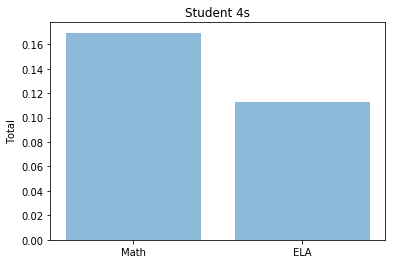

In [16]:
bars = ('Math', 'ELA')

y_pos = np.arange(len(bars))
totals = [np.mean(df['Math Prop 4']), np.mean(df['ELA Prop 4'])]

plt.bar(y_pos, totals, align='center', alpha=0.5)
plt.xticks(y_pos, bars)
plt.ylabel('Total')
plt.title('Student 4s')

plt.show()

Text(0.5, 0, 'group')

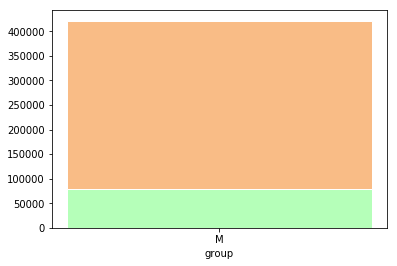

In [31]:
"""
    This is an in progress graph creation of the same graph above but color coded for how many 4s were
    gotten out of all
"""

r = [1]

barWidth = 0.85
names = ('Math')
# Create green Bars
greenBars = sum(df['Math Tested 4s'])
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth)
orangeBars = sum(df['Math Tested Total'])
# Create orange Bars
plt.bar(r, orangeBars - greenBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth)
# # Create blue Bars
# plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', width=barWidth)
plt.xticks(r, names)
plt.xlabel("group")


In [32]:
import colorsys

def get_N_HexCol(N=5):
    HSV_tuples = [(x * 1.0 / N, 0.5, 0.5) for x in range(N)]
    hex_out = []
    for rgb in HSV_tuples:
        rgb = map(lambda x: int(x * 255), colorsys.hsv_to_rgb(*rgb))
        hex_out.append('#%02x%02x%02x' % tuple(rgb))
    return hex_out

Income Bin
low        2468
medium     4874
high        604
highest      88
dtype: int64


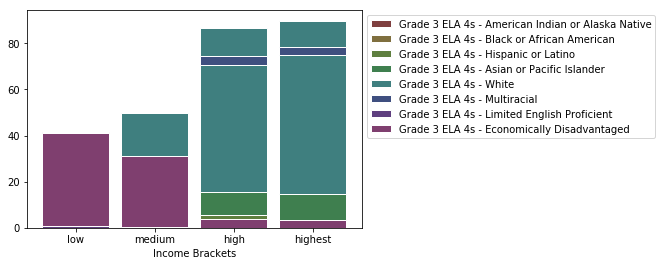

In [33]:
"""
I want to write a function to abstract the idea I just made above

I want to take in a categorical column to split the data by

I want to take a list of columns to create a stacked bar chart based on the data there
"""
def stackedBarSplit(categorical, data_cols, xlabel, aggfunc = 'sum', bar_width = 0.85,
                   colors = ['#b5ffb9', '#f9bc86', '#a3acff'], labels = 'Default'):
    if labels == 'Default':
        labels = data_cols
    
    assert len(data_cols) <= len(colors), "Not enough colors sent in to graph"
    
    if aggfunc == 'sum':
        bar_df = df.groupby(categorical).sum().loc[:, data_cols]
    elif aggfunc == 'mean':
        bar_df = df.groupby(categorical).mean().loc[:, data_cols]
    else:
        assert 1 == -1, "aggfunc passed in doesn't exist within the function"
        
    # Create a dynamically generated list from 0 to the number of rows
    r = list(range(0, bar_df.shape[0]))
    
    # Totals by row for each given column
    totals = bar_df.sum(axis = 1)
    print(totals)
    bars = []
    # This gets the proportion of each data_col for each total
    # Stored as a list to be able to be graphed later
    for col in data_cols:
        bars.append( [i / j * 100 if j != 0 else i / 1 * 100 for i, j in zip(bar_df[col], totals) ] )
        
    names = list(bar_df.index)
#     print(bars)
    
    for i, bar in enumerate(bars):
        if i == 0: # First iteration
            plt.bar(r, bar, color = colors[i], edgecolor = 'white', width = bar_width, label = data_cols[i])
        else:
            plt.bar(r, bar, bottom = bars[i - 1], color = colors[i], edgecolor = 'white', width = bar_width,
                    label = data_cols[i])
        
    plt.xticks(r, names)
    plt.xlabel(xlabel)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    
    plt.show()
    
    """
    LOGIC ISSUE: If there are enough 0% within a large # of data_cols sent in, it will appear as if there is nothing
    there, instead of a lack of representation
    """
    
stackedBarSplit(categorical='Income Bin', data_cols=['Grade 3 ELA 4s - American Indian or Alaska Native',
                                                     'Grade 3 ELA 4s - Black or African American',
                                                     'Grade 3 ELA 4s - Hispanic or Latino',
                                                    'Grade 3 ELA 4s - Asian or Pacific Islander',
                                                    'Grade 3 ELA 4s - White',
                                                    'Grade 3 ELA 4s - Multiracial',
                                                    'Grade 3 ELA 4s - Limited English Proficient',
                                                    'Grade 3 ELA 4s - Economically Disadvantaged']
                , xlabel='Income Brackets', colors = get_N_HexCol(8))

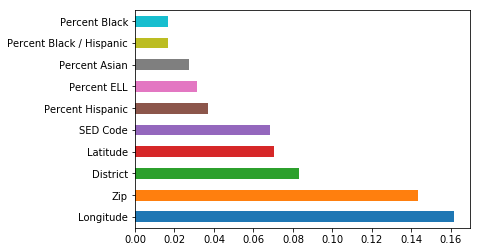

In [219]:
# Estimators specified to suppress a warning
model = ExtraTreesRegressor(n_estimators=10)
predictor = 'Grocery Store Count'
y = df[predictor].fillna(0)
X = df.drop(columns = [predictor]).select_dtypes(exclude=['object', 'category']).fillna(0)

model.fit(X, y)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
df.shape[0]

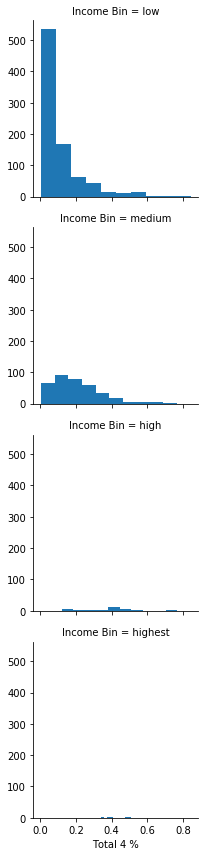

In [35]:
df2 = df[df['Total 4 %'] != 0]
g = sns.FacetGrid(df2, row = 'Income Bin')
g = g.map(plt.hist, "Total 4 %")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A93BAAF0F0>]],
      dtype=object)

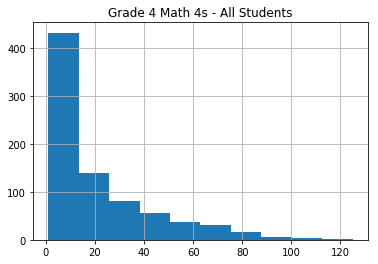

In [36]:
df[df['Grade 4 Math 4s - All Students'] != 0].hist('Grade 4 Math 4s - All Students')

# Stats

In [74]:
import scipy

In [75]:
df.head(1)

,Adjusted Grade,New?,Other Location Code in LCGMS,School Name,SED Code,Location Code,District,Latitude,Longitude,Address (Full),City,Zip,Grades,Grade Low,Grade High,Community School?,Economic Need Index,School Income Estimate,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Rigorous Instruction Rating,Collaborative Teachers %,Collaborative Teachers Rating,Supportive Environment %,Supportive Environment Rating,Effective School Leadership %,Effective School Leadership Rating,Strong Family-Community Ties %,Strong Family-Community Ties Rating,Trust %,Trust Rating,Student Achievement Rating,Average ELA Proficiency,Average Math Proficiency,Grade 3 ELA - All Students Tested,Grade 3 ELA 4s - All Students,Grade 3 ELA 4s - American Indian or Alaska Native,Grade 3 ELA 4s - Black or African American,Grade 3 ELA 4s - Hispanic or Latino,Grade 3 ELA 4s - Asian or Pacific Islander,Grade 3 ELA 4s - White,Grade 3 ELA 4s - Multiracial,Grade 3 ELA 4s - Limited English Proficient,Grade 3 ELA 4s - Economically Disadvantaged,Grade 3 Math - All Students tested,Grade 3 Math 4s - All Students,Grade 3 Math 4s - American Indian or Alaska Native,Grade 3 Math 4s - Black or African American,Grade 3 Math 4s - Hispanic or Latino,Grade 3 Math 4s - Asian or Pacific Islander,Grade 3 Math 4s - White,Grade 3 Math 4s - Multiracial,Grade 3 Math 4s - Limited English Proficient,Grade 3 Math 4s - Economically Disadvantaged,Grade 4 ELA - All Students Tested,Grade 4 ELA 4s - All Students,Grade 4 ELA 4s - American Indian or Alaska Native,Grade 4 ELA 4s - Black or African American,Grade 4 ELA 4s - Hispanic or Latino,Grade 4 ELA 4s - Asian or Pacific Islander,Grade 4 ELA 4s - White,Grade 4 ELA 4s - Multiracial,Grade 4 ELA 4s - Limited English Proficient,Grade 4 ELA 4s - Economically Disadvantaged,Grade 4 Math - All Students Tested,Grade 4 Math 4s - All Students,Grade 4 Math 4s - American Indian or Alaska Native,Grade 4 Math 4s - Black or African American,Grade 4 Math 4s - Hispanic or Latino,Grade 4 Math 4s - Asian or Pacific Islander,Grade 4 Math 4s - White,Grade 4 Math 4s - Multiracial,Grade 4 Math 4s - Limited English Proficient,Grade 4 Math 4s - Economically Disadvantaged,Grade 5 ELA - All Students Tested,Grade 5 ELA 4s - All Students,Grade 5 ELA 4s - American Indian or Alaska Native,Grade 5 ELA 4s - Black or African American,Grade 5 ELA 4s - Hispanic or Latino,Grade 5 ELA 4s - Asian or Pacific Islander,Grade 5 ELA 4s - White,Grade 5 ELA 4s - Multiracial,Grade 5 ELA 4s - Limited English Proficient,Grade 5 ELA 4s - Economically Disadvantaged,Grade 5 Math - All Students Tested,Grade 5 Math 4s - All Students,Grade 5 Math 4s - American Indian or Alaska Native,Grade 5 Math 4s - Black or African American,Grade 5 Math 4s - Hispanic or Latino,Grade 5 Math 4s - Asian or Pacific Islander,Grade 5 Math 4s - White,Grade 5 Math 4s - Multiracial,Grade 5 Math 4s - Limited English Proficient,Grade 5 Math 4s - Economically Disadvantaged,Grade 6 ELA - All Students Tested,Grade 6 ELA 4s - All Students,Grade 6 ELA 4s - American Indian or Alaska Native,Grade 6 ELA 4s - Black or African American,Grade 6 ELA 4s - Hispanic or Latino,Grade 6 ELA 4s - Asian or Pacific Islander,Grade 6 ELA 4s - White,Grade 6 ELA 4s - Multiracial,Grade 6 ELA 4s - Limited English Proficient,Grade 6 ELA 4s - Economically Disadvantaged,Grade 6 Math - All Students Tested,Grade 6 Math 4s - All Students,Grade 6 Math 4s - American Indian or Alaska Native,Grade 6 Math 4s - Black or African American,Grade 6 Math 4s - Hispanic or Latino,Grade 6 Math 4s - Asian or Pacific Islander,Grade 6 Math 4s - White,Grade 6 Math 4s - Multiracial,Grade 6 Math 4s - Limited English Proficient,Grade 6 Math 4s - Economically Disadvantaged,Grade 7 ELA - All Students Tested,Grade 7 ELA 4s - All Students,Grade 7 ELA 4s - American Indian or Alaska Native,Grade 7 ELA 4s - Black or African American,Grade 7 ELA 4s - His

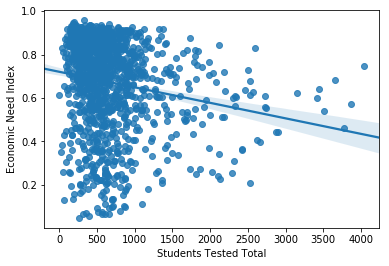

In [85]:
sns.regplot('Students Tested Total', 'Economic Need Index', data = df)

In [83]:
scipy.stats.pearsonr( df['Students Tested Total'].fillna(0), df['Economic Need Index'].fillna(0) )

(-0.09746976821750203, 0.000499277339032201)

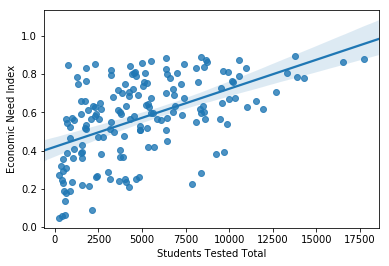

In [86]:
sns.regplot('Students Tested Total', 'Economic Need Index', data = zip_df)

In [87]:
scipy.stats.pearsonr( zip_df['Students Tested Total'].fillna(0), zip_df['Economic Need Index'].fillna(0) )

(0.5186565059198325, 5.0722465984718e-13)